# Introdução ao LangGraph

LangGraph é um framework para criar aplicações usando fluxos de trabalho baseados em grafos. Cada nó representa uma função ou etapa computacional, e as arestas definem o fluxo entre esses nós com base em certas condições.

## Características principais:
- Gerenciamento de estado
- Roteamento flexível
- Persistência
- Visualização

## Visão Geral do Tutorial: Pipeline de Análise de Texto

Neste tutorial, demonstraremos o poder do LangGraph construindo um pipeline de análise de texto em várias etapas. Nosso caso de uso se concentrará no processamento de um determinado texto através de três estágios principais:

1. **Classificação de Texto**: Categorizaremos o texto de entrada em categorias predefinidas (por exemplo, Notícias, Blog, Pesquisa ou Outro).
2. **Extração de Entidades**: Identificaremos e extrairemos entidades-chave como pessoas, organizações e locais do texto.
3. **Resumo de Texto**: Por fim, geraremos um resumo conciso do texto de entrada.

Este pipeline demonstra como o LangGraph pode ser usado para criar um fluxo de trabalho modular e extensível para tarefas de processamento de linguagem natural. Ao final deste tutorial, você entenderá como construir uma aplicação baseada em grafos que pode ser facilmente modificada ou expandida para várias necessidades de análise de texto.

### Importar Bibliotecas Necessárias
Esta célula importa todos os módulos e classes necessários para nosso tutorial do LangGraph.

In [1]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

from dotenv import load_dotenv

# Importações para manipulação de sistema e tipos
# Importações do LangGraph para criação do grafo de estado
# Importações do LangChain para prompts, modelos de linguagem e mensagens
# Importação para visualização do grafo
# Importações para exibição no Jupyter
# Importação para carregar variáveis de ambiente

### Configurar a Chave da API
Esta célula carrega as variáveis de ambiente e configura a chave da API do OpenAI. Certifique-se de ter um arquivo `.env` com sua `OPENAI_API_KEY`.

In [ ]:
# Carregar variáveis de ambiente
load_dotenv()

# Configurar a chave da API do OpenAI
os.environ["OPENAI_API_KEY"] =''

## Construindo o Pipeline de Processamento de Texto

### Definir Estado e Inicializar LLM
Aqui definimos a classe State para armazenar os dados do nosso fluxo de trabalho e inicializamos o modelo ChatOpenAI.

In [13]:
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### Definir Funções dos Nós
Estas funções definem as operações realizadas em cada nó do nosso grafo: classificação, extração de entidades e resumo.

In [14]:
def classification_node(state: State):
    ''' Classifica o texto em uma das categorias: Notícias, Blog, Pesquisa ou Outro '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classifique o seguinte texto em uma das categorias: Notícias, Blog, Pesquisa ou Outro.\n\nTexto:{text}\n\nCategoria:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    classification = llm.predict_messages([message]).content.strip()
    return {"classification": classification}


def entity_extraction_node(state: State):
    ''' Extrai todas as entidades (Pessoa, Organização, Local) do texto '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extraia todas as entidades (Pessoa, Organização, Local) do seguinte texto. Forneça o resultado como uma lista separada por vírgulas.\n\nTexto:{text}\n\nEntidades:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    entities = llm.predict_messages([message]).content.strip().split(", ")
    return {"entities": entities}


def summarization_node(state: State):
    ''' Resume o texto em uma frase curta '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Resuma o seguinte texto em uma frase curta.\n\nTexto:{text}\n\nResumo:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    summary = llm.predict_messages([message]).content.strip()
    return {"summary": summary}

### Criar Ferramentas e Construir Fluxo de Trabalho
Esta célula constrói o fluxo de trabalho StateGraph.

In [15]:
workflow = StateGraph(State)

# Adicionar nós ao grafo
workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)

# Adicionar arestas ao grafo
workflow.set_entry_point("classification_node") # Definir o ponto de entrada do grafo
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", "summarization")
workflow.add_edge("summarization", END)

# Compilar o grafo
app = workflow.compile()

## Visualizando o Fluxo de Trabalho
Esta célula cria uma representação visual do nosso fluxo de trabalho usando Mermaid

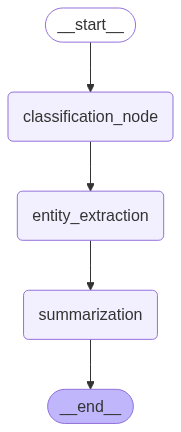

In [16]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Testando o Pipeline
Esta célula executa um texto de exemplo através do nosso pipeline e exibe os resultados.

In [17]:
sample_text = """
Post do Linkedin Influencer Samuel Fernando: Quase todos os dias eu recebo mensagem com perguntas do que eu recomendo de cursos e formação em GenAI/LLM.

Eu tenho uma opinião muito forte sobre todos os cursos, imersões e essas coisas de "formação de IA para executivos" oferecidos por influenciadores famosos, escolas de negócios e plataformas de cursos. Costumo chamar de oba-oba. 

Portanto, eu, Samuel, que estudo, trabalho, pesquiso e divulgo IA desde 2016, NUNCA RECOMENDO. Se quiser eu explico meus motivos. IA Generativa é um assunto ultraespecializado com técnicas, papers e ferramentas recentes surgindo diariamente. Mas não é só isso. 

Entretanto, agora temos o Scoras Academy para recomendar com trilhas avançadas de assuntos e técnicas emergentes usadas em IA: SLMs, Agentics Workflows, AI Agents From Scratch, LLM Routing, etc.

Ninguém no Brasil, nesse momento, conhece isso com profundidade, do hands-on à estratégia de business e produtização de IA Generativa, mais do que o colega Anderson Amaral, que é um pioneiro brasileiro nesse negócio. 

"""

state_input = {"text": sample_text}
result = app.invoke(state_input)

print("Classificação:", result["classification"])
print("\nEntidades:", result["entities"])
print("\nResumo:", result["summary"])

Classificação: Blog

Entidades: ['Samuel Fernando', 'Scoras Academy', 'Anderson Amaral']

Resumo: Samuel Fernando critica cursos de IA oferecidos por influenciadores e recomenda o Scoras Academy, que oferece formação avançada em IA Generativa, destacando a expertise de Anderson Amaral.


## Conclusão

Neste tutorial, nós:
- Exploramos os conceitos do LangGraph
- Construímos um pipeline de processamento de texto
- Demonstramos o uso do LangGraph em fluxos de trabalho de processamento de dados
- Visualizamos o fluxo de trabalho usando Mermaid

Este exemplo mostra como o LangGraph pode ser usado para tarefas além de agentes conversacionais, fornecendo um framework flexível para criar fluxos de trabalho complexos baseados em grafos.